In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from autoencoder import ToyDetectors, DEDXEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow.keras.backend as K

from __future__ import absolute_import ,division ,print_function
from scipy.optimize import curve_fit
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


tfd = tfp.distributions
tfe = tf.contrib.eager
tfb = tfp.bijectors


print(tf.__version__)
print(tfp.__version__)

Welcome to JupyROOT 6.10/08
1.12.0
0.5.0


In [2]:
TD = ToyDetectors()
DFTD = TD.GenerateToyParticles().sample(frac=1)

In [3]:
DFTD.head()

,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,pmeas,p,particle
1548,1.589041,0.002926,0.003653,1.014703,1.697001,1.634526,1.736212,1.206724,1.000000,5.097736,5.141331,0
30084,1.005537,0.001686,0.001545,0.934518,0.916914,1.020438,0.903195,1.082428,0.933983,0.360170,0.363329,2
12565,1.573051,0.002512,0.002371,1.005227,1.616690,1.616417,1.266294,1.618386,0.999999,0.335308,0.342642,0
54379,1.023022,0.001719,0.001734,0.929806,1.123339,1.058266,0.946390,0.936387,0.914853,1.119229,1.119247,3
29416,1.231647,0.001986,0.002171,1.004406,1.411121,1.296497,1.333694,1.231800,0.999385,3.858934,3.962565,2


In [4]:
signal = DFTD.query("particle!=1")[["TPCROC0"]]

In [5]:
p = DFTD.query("particle!=1")[["p"]]

In [6]:
signalnp = np.array(signal)
pnp = np.array(p)

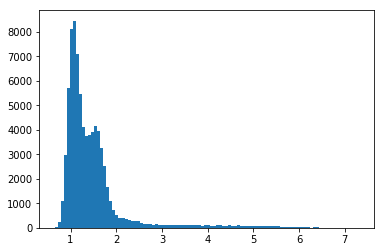

In [7]:
plt.hist(signalnp, bins = 100)
plt.show()

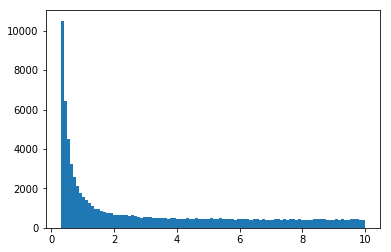

In [8]:
plt.hist(pnp, bins = 100)
plt.show()

In [9]:
def BetheBlochAleph(bg,kp1,kp2,kp3,kp4,kp5):# ,kp1=0.76176e-1,kp2=10.632,kp3=0.13279e-4,kp4=1.8631,kp5=1.9479):
            beta = bg/tf.sqrt(1.+ bg*bg)
            aa   = tf.exp(kp4*tf.log(beta))
            bb   = tf.exp(-kp5*tf.log(bg))
            bb   = tf.log(kp3+bb)
            return (kp2-aa-bb)*kp1/aa

In [10]:
mass_e = 0.000511
mass_pi = 0.139    
mass_K = 0.494
mass_p = 0.938

In [11]:
def BetheBlochAlephNP(bg,kp1=0.76176e-1,kp2=10.632,kp3=0.13279e-4,kp4=1.8631,kp5=1.9479):
        beta = bg/np.sqrt(1.+ bg*bg)
        aa   = np.exp(kp4*np.log(beta))
        bb   = np.exp(-kp5*np.log(bg))
        bb   = np.log(kp3+bb)
        return (kp2-aa-bb)*kp1/aa

In [12]:
x = pnp
y = signalnp

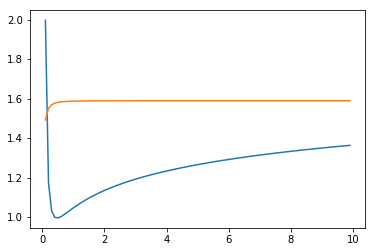

In [13]:
t = np.arange(0.1, 10., 0.1)
plt.plot(t, BetheBlochAlephNP(t/mass_pi),t , BetheBlochAlephNP(t/mass_e))

In [14]:
def log_prob(x, y, kp1, kp2, kp3, kp4, kp5): 
    pi_mean = BetheBlochAleph(x/mass_pi,kp1,kp2,kp3,kp4,kp5)
    e_mean = BetheBlochAleph(x/mass_e,kp1,kp2,kp3,kp4,kp5) 
    p_mean = BetheBlochAleph(x/mass_p,kp1,kp2,kp3,kp4,kp5) 
    K_mean = BetheBlochAleph(x/mass_K,kp1,kp2,kp3,kp4,kp5)
    
    pi_sigma=0.1*pi_mean
    e_sigma =0.1*e_mean
    p_sigma =0.1*p_mean
    K_sigma =0.1*K_mean
    
    p_pi    = tfd.Normal(loc=pi_mean,scale=pi_sigma).prob(y)
    p_e     = tfd.Normal(loc= e_mean,scale= e_sigma).prob(y)
    p_p     = tfd.Normal(loc= p_mean,scale= p_sigma).prob(y)
    p_K     = tfd.Normal(loc= K_mean,scale= K_sigma).prob(y)
    
    
    lnp = tf.log((p_pi   + p_e + p_p + p_K)/4.)
    
    extraloss = - 1e3*(kp3-0.13279e-4)**2
    return tf.reduce_mean(lnp) + extraloss


unnormalized_posterior_log_prob = lambda *args: log_prob(x,y, *args)

In [15]:
kp1 = tf.Variable(0.7 ,dtype=tf.float64,name="kp1") # 0.76176e-1
kp2 = tf.Variable(12.0,dtype=tf.float64,name="kp2") # 10.632
kp3 = tf.Variable(0.13279e-4,dtype=tf.float64,name="kp3")
kp4 = tf.Variable(2.0,dtype=tf.float64,name="kp4") # 1.8631
kp5 = tf.Variable(2.2,dtype=tf.float64,name="kp5") # 1.9479




In [16]:
loss=-unnormalized_posterior_log_prob(kp1,kp2,tf.sqrt(kp3**2),kp4,kp5)
optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
trainer  =optimizer.minimize(loss,var_list=[kp1,kp2,kp3,kp4,kp5])

In [ ]:
#init =tf.global_variables_initializer() 
#with tf.Session() as session:
#    session.run(init)
#    print(session.run(loss))

In [17]:
init =tf.global_variables_initializer() 
with tf.Session() as session:
    session.run(init)
    for _ in range(5000):
        l1=session.run(loss)
        session.run(trainer)
        l2=session.run(loss)
        kp1_v=session.run(kp1)
        kp2_v=session.run(kp2)
        kp3_v=np.abs(session.run(kp3))
        kp4_v=session.run(kp4)
        kp5_v=session.run(kp5)
        
        
        print("loss (prev): ",l1,"loss (post): ",l2)
        print(kp1_v,kp2_v,kp3_v,kp4_v,kp5_v)
        print()


loss (prev):  39.38830483021865 loss (post):  38.54130150784797
0.690001657698999 11.990637327397486 0.010013277388466803 1.99154671647018 2.1903078436059786

loss (prev):  38.54130150784797 loss (post):  38.38926225355482
0.6827695864040598 11.98370991174568 0.010413575691354399 1.986751019021705 2.1862550784677044

loss (prev):  38.38926225355482 loss (post):  38.26150963889701
0.6768338379633375 11.977974644182073 0.01078852007483538 1.9824281355722246 2.18250726711493

loss (prev):  38.26150963889701 loss (post):  38.148508054452854
0.6716676956267131 11.97296602994441 0.011139880711809652 1.9784635993158723 2.1790076381689483

loss (prev):  38.148508054452854 loss (post):  38.04572977721989
0.6670256205910214 11.968459358171877 0.011469467195362355 1.974781965668705 2.1757138798876

loss (prev):  38.04572977721989 loss (post):  37.95058709188118
0.6627698588925467 11.964326075443235 0.01177897145998101 1.9713305905515672 2.172593874543166

loss (prev):  37.95058709188118 loss (pos

KeyboardInterrupt: 

2019-02-15 16:08:40.712962: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [ ]:
out = pd.DataFrame([kp1_v, kp2_v, kp3_v, kp4_v, kp5_v])

In [ ]:
out.transpose().to_csv("MCMCresults.csv")